# Numerical exercises 11
____________________________

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

import matplotlib.style as style 
style.use('tableau-colorblind10')

In this notebook our task is to perdorm machine learning regression on noisy data with a Neural Network (NN) of the feedforward type, where information always moves in one direction. 

The universal approximation theorem guarantees that Neural Networks can transform (non linearly) the input $X$ into an output $Y$ that depends on the weights and biases of all the neurons in the network, whatever it is the form of the function that links $X$ to $Y$. The choice of the parameters internal to the network is done in the training phase. The structure of the neural network has embedded an activation function $\Phi_i^j$ that defines the behaviour of the nodes:

$$
\psi_i^j (\vec{x}_{j-1}) = \phi_i^j \ (\ \vec{x}_{j-1} \cdot \vec{w}_{i,j} + \ b_{i,j}) = x_{i,j},
$$

where ${x}_{j-1}$ is the output vector of the previous layer and  $\vec{w}_{i,j}$, $b_{i,j}$ are the wights and the biases of the current neuron.
We will use [Keras](https://keras.io/) as an Application Programming Interface (API), and in particular we will use the [Sequential model](https://keras.io/guides/sequential_model/) to structure the layers of our network.

We will try to solve the **prediction problem**. Given a probabilistic process that gives rise to the labeled data $(x,y)$, with $y_i = f(x_i)+\eta_i$, $\eta_i$ gaussian and uncorrelated noise such that: $\langle \eta_i \rangle=0$ and $\langle \eta_i \eta_j \rangle=\delta_{ij}\sigma$, the output of our neural network will provide us with a set of prediction $\{ y_j^{\text{pred}} \}$. To measure the goodness of our hypothesis we measure on the test set the sum of the mean square error (MSE).

$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

## Exercise 11.1: Linear regression with Neural Network (NN)
__________________________

In this exercise we have a dataset distributed following:

$$
f(x) = 2x +1.
$$

In this case a network of a single layer and a single neuron is enough to tackle the probelem, using the identity as the activation function (we are trying to fit linear data):

$$
\psi^j (x_{j-1}) = \phi^j ( x_{j-1} w_j +  b_j) =  x_{j-1} w_j +  b_j = y_j.
$$

The only parameters to be optimized will be $w_j$ and $b_j$. An example of training was provided, but as we will see its results are still unsatisfying. To make practice with NN, we will work on improving it by changing the parameters. The parameters used where: $N_{\text{train}}=100$ and $N_{\text{valid}}=10$ (our test values, in this case directly sampled from the analytical model). Our network was trained using **30 epochs**, the noise is $\sigma=0$.

As a first thing, we generate & plot the data that will be used as training set and test set. Then we will compose the model and train the neural network to see how well it behaves with these first choice of parameters.

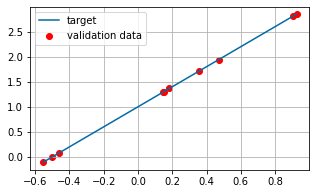

In [262]:
# target parameters of f(x) = m*x + b
m = 2 # slope
b = 1 # intersect

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 100)
x_valid = np.random.uniform(-1, 1, 10)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.0 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

plt.figure(figsize=(5,3))
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.grid(True); plt.legend(); plt.show(); 

In [263]:
# compose the NN model
model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
# get a summary of our composed model
model.summary()

# save the weights that we will use later
model.save_weights('model.h5')

# fit the model using training dataset
# over 10 epochs of 32 batch size each
# report training progress against validation data
history = model.fit(x=x_train, y=y_train, 
            batch_size=32, epochs=30,
            shuffle=True, # a good idea is to shuffle input before at each epoch
            validation_data=(x_valid, y_valid),
            verbose = 0)
print('Done!') 

def plot_model(): 
    par = model.get_weights()

    print('\n\n------------------------------------------------------\n')
    print('The model function obtained is: \n\nf(x) = '+ str(float(par[0]))+'x + ' +str(float(par[1])))
    print('\n\n------------------------------------------------------')

    # look into training history
    # Plot training & validation loss values
    plt. subplots(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss', fontsize=16)
    plt.grid()
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='best')

    # Plot target and fit
    plt.subplot(1,2,2)
    plt.title('Target function and predicted function', fontsize=16)
    x_predicted = np.random.uniform(-1, 1, 100)
    y_predicted = model.predict(x_predicted)
    # Fitted function
    plt.plot(x_predicted, y_predicted,'ro', label='predicted')
    # Target function
    plt.plot(x_valid, y_target, label='target')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_perf(model, y_target, x_valid, y_valid, bsize):
    print('\n\n------------------------------------------------------\n')
    # evaluate model
    score = model.evaluate(x_valid, y_valid, batch_size=bsize, verbose=1)
    # print performance
    print()
    print('Evaluation of the model using the validation set:')
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    # evaluate model with the exact curve
    print('\n\n------------------------------------------------------------------')
    score = model.evaluate(x_valid, y_target, batch_size=32, verbose=1)

    # print performance
    print()
    print('Evaluation of the model by comparison with the exact curve:')
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    print('\n\n------------------------------------------------------')


Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_388 (Dense)            (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Done!




------------------------------------------------------

The model function obtained is: 

f(x) = 1.034903645515442x + 0.8360401391983032


------------------------------------------------------


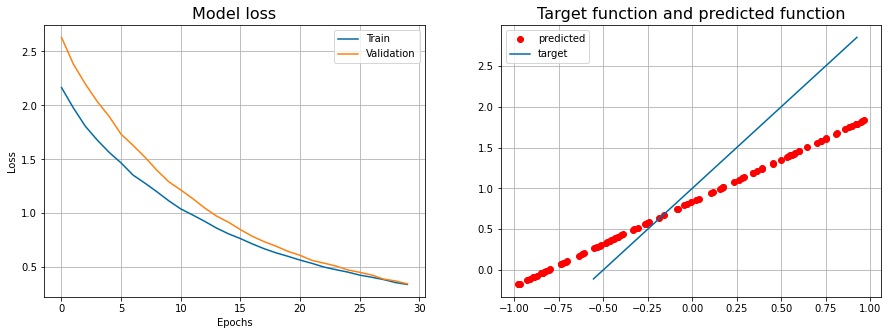



------------------------------------------------------

1/1 [==============================] - 0s 20ms/step - loss: 0.3456 - mse: 0.3456

Evaluation of the model using the validation set:
Test loss: 0.34556835889816284
Test accuracy: 0.34556835889816284


------------------------------------------------------------------
1/1 [==============================] - 0s 17ms/step - loss: 0.3456 - mse: 0.3456

Evaluation of the model by comparison with the exact curve:
Test loss: 0.34556835889816284
Test accuracy: 0.34556835889816284


------------------------------------------------------


In [264]:
plot_model()
plot_perf(model, y_target, x_valid, y_valid, 32)

### Comment on the results: we need more epochs

We now show the results obatined in this way, and then we analyze the performance of the model obtained. From the graph of the predicted and target model, the failure of the model is clear. It can't describe our data in a good way. The silver lining can be found looking at the loss function graph in function of the epochs: the loss is reduced as the number of epochs is increased, and it looks like there is still something to gain from a bigger number of epochs, since the loss funciton approaching 30 epochs is very steep. **Our first improvement naturally seems to be an increase in the number of epochs.**

We proceed by setting the number of epochs to 100. This means that the neural network will have to process the training set 100 times, and should lead to a better interpretation of data patterns. 


In [265]:
model.load_weights('model.h5')
history = model.fit(x=x_train, y=y_train, 
            batch_size=32, epochs=100,
            shuffle=True, # a good idea is to shuffle input before at each epoch
            validation_data=(x_valid, y_valid),
            verbose = 0)
print('Done!') 

Done!




------------------------------------------------------

The model function obtained is: 

f(x) = 1.8513462543487549x + 0.9890795946121216


------------------------------------------------------


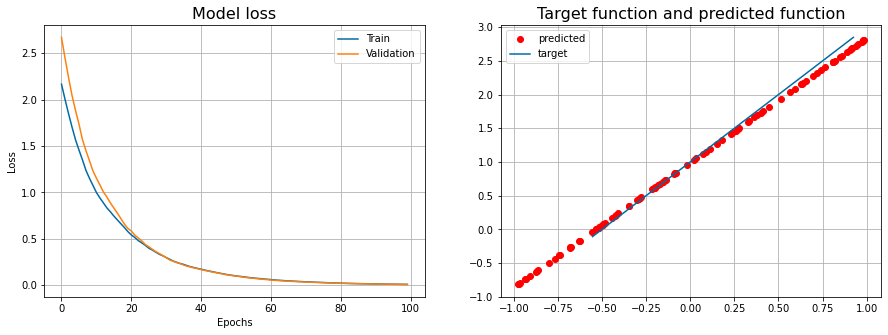



------------------------------------------------------

1/1 [==============================] - 0s 16ms/step - loss: 0.0070 - mse: 0.0070

Evaluation of the model using the validation set:
Test loss: 0.006989526562392712
Test accuracy: 0.006989526562392712


------------------------------------------------------------------
1/1 [==============================] - 0s 20ms/step - loss: 0.0070 - mse: 0.0070

Evaluation of the model by comparison with the exact curve:
Test loss: 0.006989526562392712
Test accuracy: 0.006989526562392712


------------------------------------------------------


In [266]:
plot_model()
plot_perf(model, y_target, x_valid, y_valid, 32)

### Comment on the results: we need more training points


The results are significantly better, but from the loss plot we can see that we are not going to gain much from a new increase in the number of epochs, since the variation of the loss function has reached a very small value. 

Our visual impressions are confirmed by the evaluation of the losses, much smaller than in the previous case.

Still, to improve our model, we can try feeding it with **a larger training set**: $N_{\text{train}}=1000$. We will set the number of epochs back to 30, to have an idea of the improvement brought by the increase of training points alone.

In [267]:
model.load_weights('model.h5')

In [268]:
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000) # <--- We changed this number!
x_valid = np.random.uniform(-1, 1, 100)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function
sigma = 0.0 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

In [269]:
history = model.fit(x=x_train, y=y_train, 
            batch_size=32, epochs=30,
            shuffle=True, # a good idea is to shuffle input before at each epoch
            validation_data=(x_valid, y_valid),
            verbose = 0)
print('Done!') 

Done!




------------------------------------------------------

The model function obtained is: 

f(x) = 1.9969568252563477x + 0.99996417760849


------------------------------------------------------


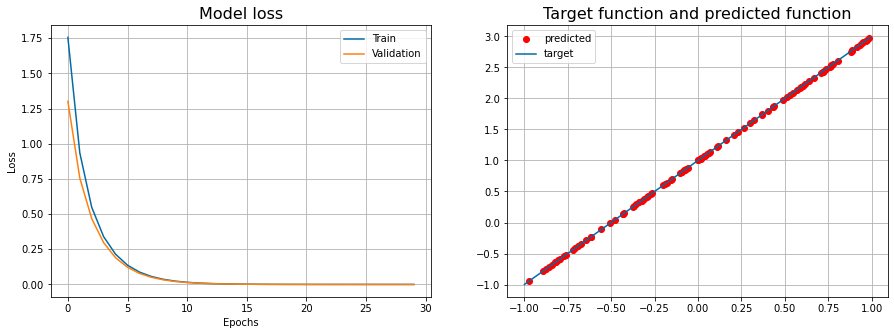



------------------------------------------------------

4/4 [==============================] - 0s 1ms/step - loss: 3.5852e-06 - mse: 3.5852e-06

Evaluation of the model using the validation set:
Test loss: 3.585190597732435e-06
Test accuracy: 3.585190597732435e-06


------------------------------------------------------------------
4/4 [==============================] - 0s 1ms/step - loss: 3.5852e-06 - mse: 3.5852e-06

Evaluation of the model by comparison with the exact curve:
Test loss: 3.585190597732435e-06
Test accuracy: 3.585190597732435e-06


------------------------------------------------------


In [270]:
plot_model()
plot_perf(model, y_target, x_valid, y_valid, 32)

### Comment on the results: more training is better than more epochs

From the data we can see that a larger training set provides loss values much smaller than those previously obtained. The loss function coverges to zero after 15 epochs, so its unnecessary to train the neural network on a larger set of epochs. In summary: when possible, it is good to give to the network more examples to train!

We now go on to study, with the same parameters, what happens when the **training data are noisy**: $\sigma = 0.6$.

In [271]:
model.load_weights('model.h5')

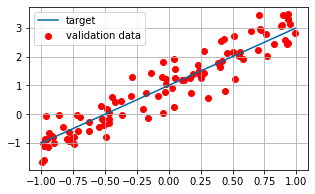

In [272]:
# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 1000) 
x_valid = np.random.uniform(-1, 1, 100)
x_valid.sort()
y_target = m * x_valid + b # ideal (target) linear function

sigma = 0.5 # noise standard deviation: NOT ZERO!        
y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(m * x_valid + b, sigma)

plt.figure(figsize=(5,3))
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.grid(True); plt.legend(); plt.show(); 

In [273]:
history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=30,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid),
          verbose = 0 # I don't want a huge print
          )
print('Done!')

Done!




------------------------------------------------------

The model function obtained is: 

f(x) = 1.9993348121643066x + 0.9991937875747681


------------------------------------------------------


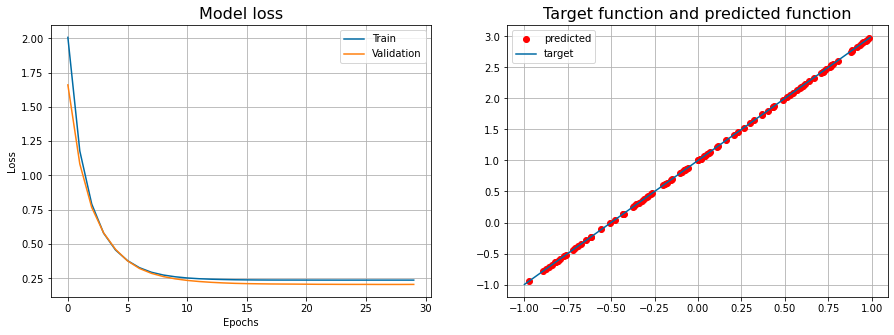



------------------------------------------------------

4/4 [==============================] - 0s 1ms/step - loss: 0.2058 - mse: 0.2058

Evaluation of the model using the validation set:
Test loss: 0.20579715073108673
Test accuracy: 0.20579715073108673


------------------------------------------------------------------
4/4 [==============================] - 0s 2ms/step - loss: 7.7972e-07 - mse: 7.7972e-07

Evaluation of the model by comparison with the exact curve:
Test loss: 7.797212902005413e-07
Test accuracy: 7.797212902005413e-07


------------------------------------------------------


In [274]:
plot_model()
plot_perf(model, y_target, x_valid, y_valid, 32)

### Comment of the results: we are not overfitting too much

The results obtained are very good: the loss computed with the validation set is much higher than the one computed using the target function. This means that we are fitting the model, but not overfitting the noise of the training data. We can also see that by increasing the number of epochs, the loss obtained on the training set saturates on a higher value with respect to the loss on the valudation set. This as well seems to be an indication of the goodness of the model.

## Exercise 11.2: extension of the model to fit of a polynomial of order 3
______________________________

Now let's consider the following function:

$$
f(x)=4-3x-2x^2+3x^3, \quad \text{for } x \in [-1,1].
$$

It is a polynomial function of order three, defined on a compact interval. 

As we previously mentioned, thanks to the use of non linear activation functions and multiple layers, neural networks become nonlinear transformations of the inputs X into an output Y. In particular, the universal approximation theorem states that a neural network with a
single hidden layer can approximate any continuous, multi-input/multi-output function with arbitrary accuracy.

We now try to build such a network with to fit our polynomial function. We will work on:
- Testing the linear NN as it is;
- Increasing the number of hidden layers;
- Increasing the number of neurons in the single layer;
- Increasing both the number the number of hidden layers and of neurons in each layer.


First, we define the data and the function's shape. Then we compile the models and fit them with the data that we randomly generated. Finally we print the performances of each model and we plot the loss evolutions in function of the number of epochs considered and we try to fit the analytical curve using our models, inside and outside the domain of the training data. We will use 150 batches and we will use 15 epochs. 

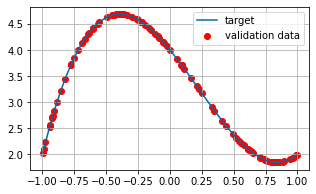

In [275]:
def polynomial(x): return a -3*x -2*x**2 + 3*x**3

# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 10000)
x_valid = np.random.uniform(-1, 1, 100)
x_valid.sort()
y_target = polynomial(x_valid) # ideal (target) linear function

sigma = 0.0 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(polynomial(x_train), sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(polynomial(x_valid), sigma)

plt.figure(figsize=(5,3))
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data')
plt.grid(True); plt.legend(); plt.show(); 

In [276]:
def compileNN(models, optimizer, loss, met):   #compile the model choosing optimizer, loss and metrics objects
    for mod in models:
        mod.compile(optimizer=optimizer, loss=loss, metrics=[met])
        mod.summary(); print()    

def history(models, x_train, y_train, x_valid, y_valid, bsize, epochs):    # fit the model using training dataset
    if type(epochs) is int: ep=[epochs for i in range(len(models))]
    else: ep=epochs
    return [models[i].fit(x = x_train, y = y_train, 
          batch_size=bsize, epochs=ep[i], shuffle=True,
          validation_data=(x_valid, y_valid), verbose=0)
          for i in range(len(models))]

In [277]:
#linear activation function
lin = tf.keras.Sequential()
lin.add(Dense(20,input_shape=(1,)))
for i in range(4): lin.add(Dense(15))
lin.add(Dense(1))

#more neurons
moreN = tf.keras.Sequential()
moreN.add(Dense(12,input_shape=(1,),activation='selu'))
moreN.add(Dense(1,activation='selu'))

#more layers
moreL = tf.keras.Sequential()
moreL.add(Dense(1,input_shape=(1,),activation='selu'))
for i in range(17): moreL.add(Dense(1,activation='selu'))

#more neurons and layers
poly1 = tf.keras.Sequential()
for i in range(4): poly1.add(Dense(1+i,input_shape=(1,),activation='selu'))
poly1.add(Dense(1,activation='selu'))

models1=[lin, moreN, moreL, poly1]
compileNN(models1, SGD(),'mse','mse')

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_389 (Dense)            (None, 20)                40        
_________________________________________________________________
dense_390 (Dense)            (None, 15)                315       
_________________________________________________________________
dense_391 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_392 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_393 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_394 (Dense)            (None, 1)                 16        
Total params: 1,091
Trainable params: 1,091
Non-trainable params: 0
___________________________________________________

In [278]:
hist1 = history(models1, x_train, y_train, x_valid, y_valid, 150, 15)

In [279]:
print('\n\n------------------------------------------------------')
print('LINEAR MODEL ')
plot_perf(models1[0], y_target, x_valid, y_valid, 150)
print('MORE NEURONS ')
plot_perf(models1[1], y_target, x_valid, y_valid, 150)
print('MORE LAYERS')
plot_perf(models1[2], y_target, x_valid, y_valid, 150)
print('MORE NEURONS & LAYERS ')
plot_perf(models1[3], y_target, x_valid, y_valid, 150)



------------------------------------------------------
LINEAR MODEL 


------------------------------------------------------

1/1 [==============================] - 0s 17ms/step - loss: 0.7277 - mse: 0.7277

Evaluation of the model using the validation set:
Test loss: 0.7277254462242126
Test accuracy: 0.7277254462242126


------------------------------------------------------------------
4/4 [==============================] - 0s 1ms/step - loss: 0.7277 - mse: 0.7277

Evaluation of the model by comparison with the exact curve:
Test loss: 0.7277254462242126
Test accuracy: 0.7277254462242126


------------------------------------------------------
MORE NEURONS 


------------------------------------------------------

1/1 [==============================] - 0s 23ms/step - loss: 0.1712 - mse: 0.1712

Evaluation of the model using the validation set:
Test loss: 0.17117232084274292
Test accuracy: 0.17117232084274292


------------------------------------------------------------------
4/4 [

In [280]:
def plot_hist(history,title):
    many=len(history)
    for i in range(many):
        plt.subplot(int((many+1)/2),2,i+1)
        plt.plot(history[i].history['loss'])
        plt.plot(history[i].history['val_loss'])
        plt.title(title[i])
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend(['Train', 'Test'], loc='best')
    plt.suptitle('Models losses')
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
    
def fit(models, x_valid, y_target):
    plt.figure(figsize=(15,6))
    for lim in range(2):
        plt.subplot(1,2,lim+1)
        x_pred = np.random.uniform(-lim-1, lim+1, 200)
        plt.plot(x_valid, y_target)
        for i in range(len(models)):
            y_pred=models[i].predict(x_pred)
            plt.scatter(x_pred,y_pred,marker='.',label=title[i])
        plt.axvline(x=-1,color='k',linewidth=0.8)
        plt.axvline(x=1,color='k',linewidth=0.8)
        if(lim==0):
            plt.xlim(-1.1,1.1)
            plt.ylim(1,5)
        plt.legend(loc='best')
        plt.grid(True)
        if(lim==0): plt.title('inside training range')
        else: plt.title('outside training range')
    plt.suptitle('NNs predictions')
    plt.show()

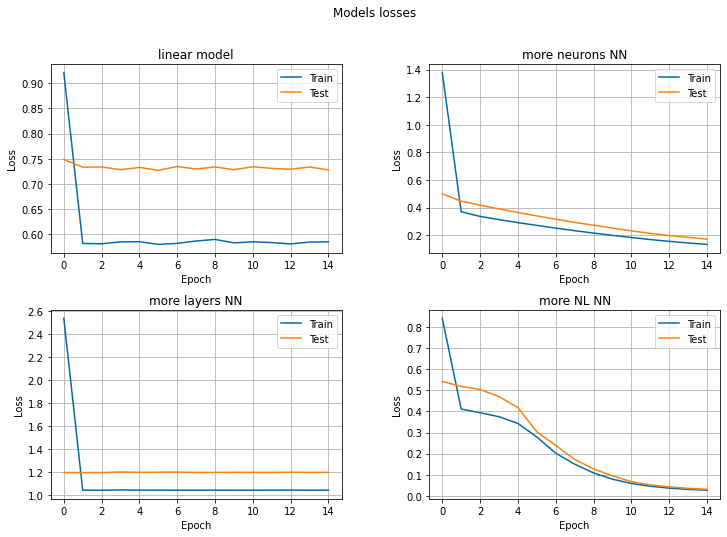

In [281]:
title=('linear model','more neurons NN','more layers NN','more NL NN')
plt.figure(figsize=(12,8))
plot_hist(hist1, title)

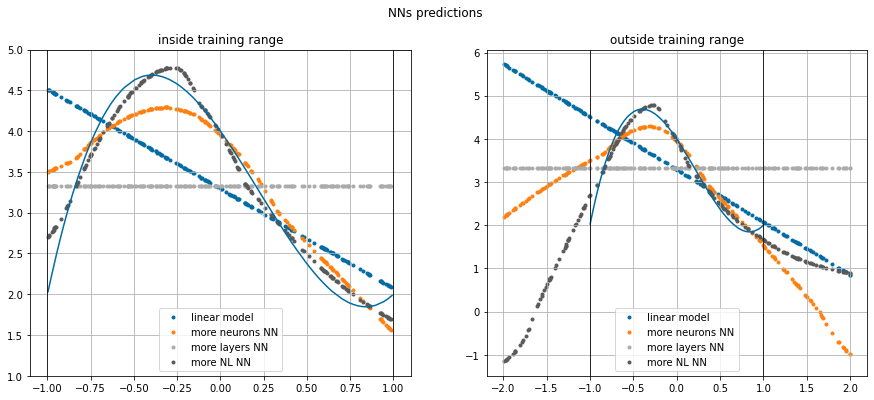

In [282]:
fit(models1, x_valid, y_target)

### Comments on the results: the linear model is not enough

From the results it is clear that our models are all very weak both inside and outside the domain of the training data, especially the linear model. The only result which is not completely off, at least inside the training domain, is the one obtained by increasing both the number of layers and the number of neurons per layer.

So we proceed testing such a NN, with 5 hidden layers and multiple neurons. The number of neurons per layer will increase the nearer it is the layer to the output one. We will consider 150 batches and 15 epochs.

We will try out different forms of activation functions: _relu_, _elu_, _selu_ and _sigmoid_.

<img src="relueluselu.png" width="400">


- The activation function;
- The optimizer;
- The loss function.


In [283]:
def composeNN(activation,big):    #big=1 for a bigger NN, big=2 for 3D case
    rg=(range(4),range(5),range(8)); dim=(1,1,2)
    def par(i): return (3+2*i,5*(i+1),5*(i+1))
    
    #compose the NN model
    model = tf.keras.Sequential()
    model.add(Dense(2,input_shape=(dim[big],),activation=activation))
    for i in rg[big]: model.add(Dense(par(i)[big],activation=activation))
    if(big==2): model.add(Dropout(0.5))
    model.add(Dense(1,activation=activation))
    return model

In [284]:
models_act=(composeNN('selu',0),composeNN('elu',0),composeNN('relu',0),composeNN('sigmoid',0))
compileNN(models_act,SGD(),'mse','mse')

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_420 (Dense)            (None, 2)                 4         
_________________________________________________________________
dense_421 (Dense)            (None, 3)                 9         
_________________________________________________________________
dense_422 (Dense)            (None, 5)                 20        
_________________________________________________________________
dense_423 (Dense)            (None, 7)                 42        
_________________________________________________________________
dense_424 (Dense)            (None, 9)                 72        
_________________________________________________________________
dense_425 (Dense)            (None, 1)                 10        
Total params: 157
Trainable params: 157
Non-trainable params: 0
_______________________________________________________

In [285]:
hist_act = history(models_act,x_train, y_train, x_valid, y_valid, 150,15)

In [286]:
print('\n\n------------------------------------------------------')
print('selu ')
plot_perf(models_act[0], y_target, x_valid, y_valid, 150)
print('elu ')
plot_perf(models_act[1], y_target, x_valid, y_valid, 150)
print('relu')
plot_perf(models_act[2], y_target, x_valid, y_valid, 150)
print('sigmoid')
plot_perf(models_act[3], y_target, x_valid, y_valid, 150)



------------------------------------------------------
selu 


------------------------------------------------------

1/1 [==============================] - 0s 19ms/step - loss: 0.0296 - mse: 0.0296

Evaluation of the model using the validation set:
Test loss: 0.02956043928861618
Test accuracy: 0.02956043928861618


------------------------------------------------------------------
4/4 [==============================] - 0s 2ms/step - loss: 0.0296 - mse: 0.0296

Evaluation of the model by comparison with the exact curve:
Test loss: 0.02956043928861618
Test accuracy: 0.02956043928861618


------------------------------------------------------
elu 


------------------------------------------------------

1/1 [==============================] - 0s 16ms/step - loss: 0.0248 - mse: 0.0248

Evaluation of the model using the validation set:
Test loss: 0.024805722758173943
Test accuracy: 0.024805722758173943


------------------------------------------------------------------
4/4 [===========

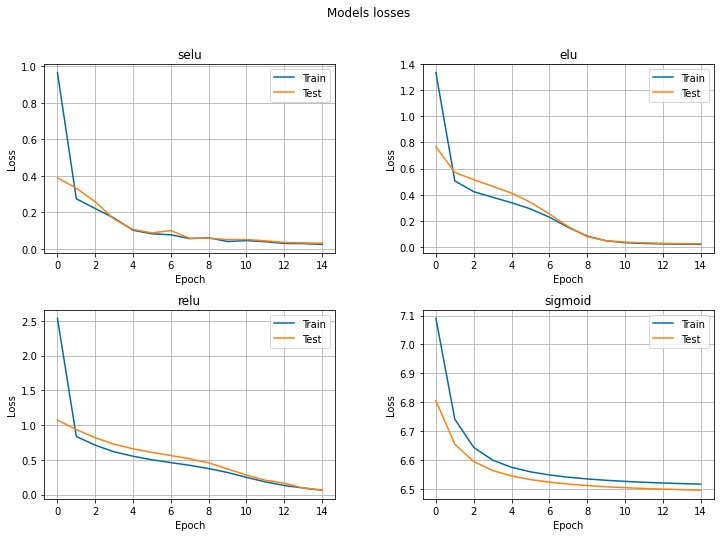

In [288]:
title=('selu','elu','relu','sigmoid')
plt.figure(figsize=(12,8))
plot_hist(hist_act,title)

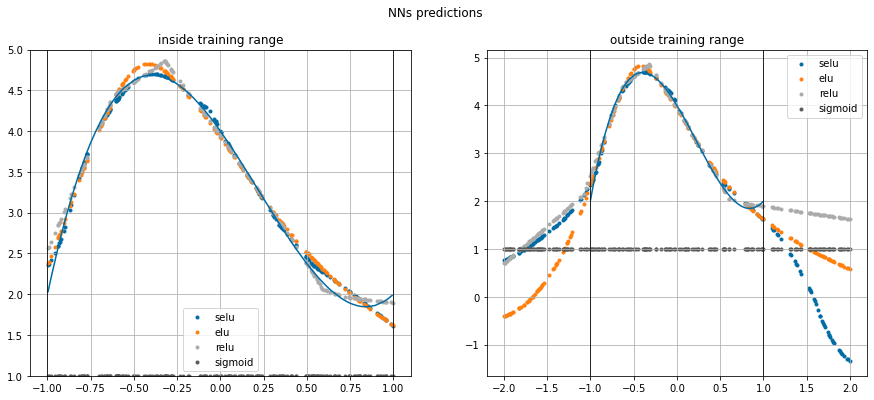

In [289]:
fit(models_act,  x_valid, y_target)

### Comments on the results: the sigmoid doesn't work

The situation has improved a little (not in the sigmoid case though) inside the training domain, but it's still far from accurate outside of it. The _elu_ function seems to be the most accurate one, according to its loss values; we choose to go on using it.

We will now test the **optimization** methods. Up until now we used the classic stochastic gradient descent. We switch to using __Adam__ and __Adadelta__.

We will also try out different **loss functions**: the **Mean Absolute Error (MAE)** and the **Mean Squared Logarithmic Error (MSLE)**.

We will test them using the same NN architecture we had before. Among the hidden layers, we will set a dropout layer to avoid overfitting. We will also consider a larger number of epochs to 30.

In [293]:
models_poly=list(composeNN('elu',1) for i in range(6))
models_poly[0].compile(optimizer=SGD(),loss='mse',metrics=['mse'])
models_poly[1].compile(optimizer=Adadelta(),loss='mse',metrics=['mse'])
models_poly[2].compile(optimizer=Adadelta(),loss='mae',metrics=['mae'])
models_poly[3].compile(optimizer=Adam(),loss='mse',metrics=['mse'])
models_poly[4].compile(optimizer=Adam(),loss='mae',metrics=['mae'])
models_poly[5].compile(optimizer=Adam(),loss='msle',metrics=['msle'])
for mod in models_poly: mod.summary(); print()

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_486 (Dense)            (None, 2)                 4         
_________________________________________________________________
dense_487 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_488 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_489 (Dense)            (None, 15)                165       
_________________________________________________________________
dense_490 (Dense)            (None, 20)                320       
_________________________________________________________________
dense_491 (Dense)            (None, 25)                525       
_________________________________________________________________
dense_492 (Dense)            (None, 1)               

In [299]:
title=('SGD, MSE','Adadelta, MSE','Adadelta, MAE','Adam, MSE','Adam, MAE','Adam, MSLE')
hist_poly = history(models_poly, x_train, y_train, x_valid, y_valid, 150, (30, 30, 30, 30, 30, 30))

In [303]:
for i in range(4):
    print('\n\n------------------------------------------------------')
    print(title[i])
    plot_perf(models_poly[i], y_target, x_valid, y_valid, 150)




------------------------------------------------------
SGD, MSE


------------------------------------------------------

1/1 [==============================] - 0s 23ms/step - loss: 0.0039 - mse: 0.0039

Evaluation of the model using the validation set:
Test loss: 0.003875719616189599
Test accuracy: 0.003875719616189599


------------------------------------------------------------------
4/4 [==============================] - 0s 2ms/step - loss: 0.0039 - mse: 0.0039

Evaluation of the model by comparison with the exact curve:
Test loss: 0.0038757198490202427
Test accuracy: 0.0038757198490202427


------------------------------------------------------


------------------------------------------------------
Adadelta, MSE


------------------------------------------------------

1/1 [==============================] - 0s 20ms/step - loss: 0.4993 - mse: 0.4993

Evaluation of the model using the validation set:
Test loss: 0.49931418895721436
Test accuracy: 0.49931418895721436


----------

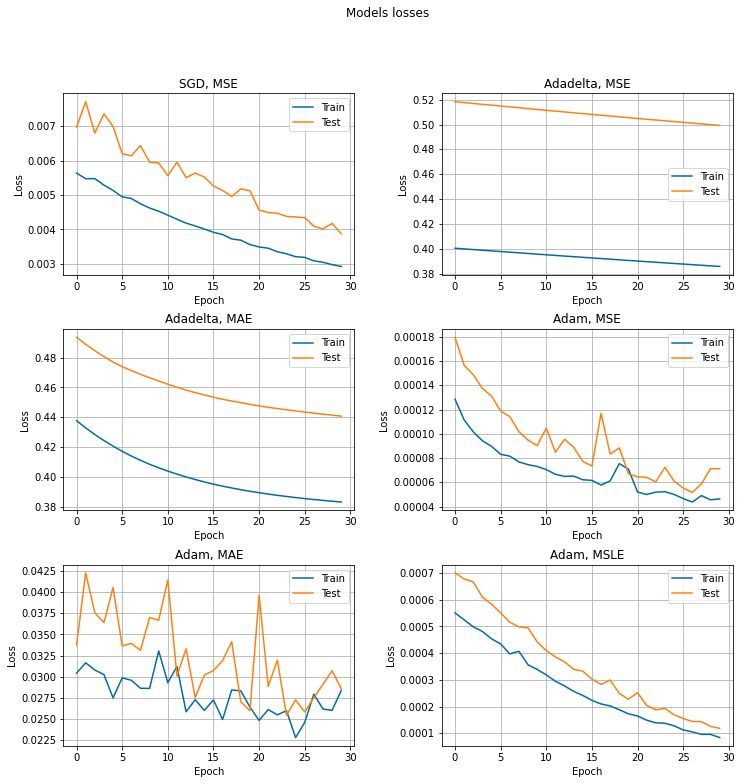

In [304]:
plt.figure(figsize=(12,12))
plot_hist(hist_poly,title)

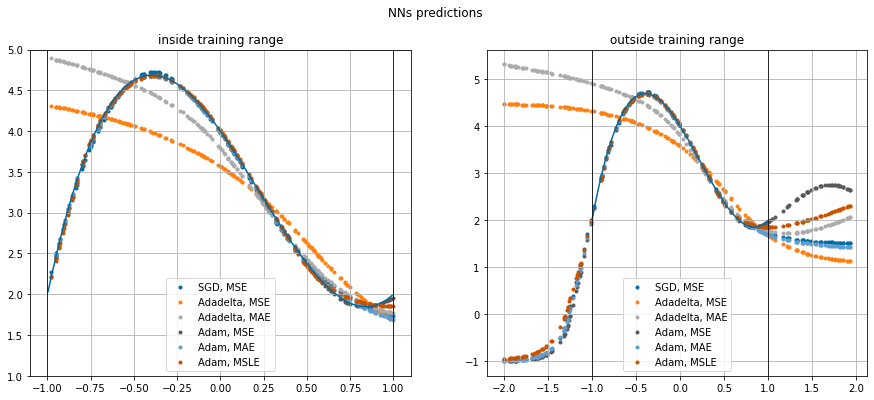

In [306]:
fit(models_poly,  x_valid, y_target)

### Comments on the results: Adam is better than Adalta

The combination of Adam as an optimization function and MSLE as a loss function gives remarkable results inside the training domain. It also looks like a bigger number of epochs could provide even better results. We can also safely say that Adadelta is not the appropriate choice here.

Outside of the training domain the situation is still unsatisfying though. It is difficult to understand how much overfitting is happening. 

## Exercise 11.3: Fitting more dimensions
__________________

Now we deal with the following function:

$$
f(x,y) = \sin(x^2+y^2), \quad \text{with } x \in [-3/2,3/2], \quad y \in [-3/2,3/2]
$$

We use the winners of the previous trials:
- __Adam__ is the optimizer;
- **MSLE** is the loss function;
- **elu** is the activation function.

Now the noise is $\sigma=0.2$, the training datas are $N_{\text{train}}=10^5$, the validation datas are $N_{\text{valid}}=10^3$. The batch size is 500, the number of epochs is 30.

In [323]:
def target3D(x,y): return np.sin(x**2 + y**2)

def plot3D(xyz,target,lab):
    fig = plt.figure(figsize=(9,5))
    ax = Axes3D(fig)
    ax.plot_trisurf(target[0],target[1],target[2],linewidth=0,antialiased=False,alpha=0.1)
    ax.scatter(xyz[0],xyz[1],xyz[2],c=xyz[2],marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(30, 30)
    plt.title('Target and '+lab, y=1.05)
    plt.show()

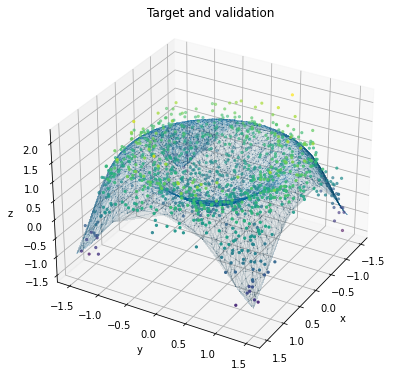

In [324]:
sigma=0.3
#generate training data
x_train = np.random.uniform(-1.5, 1.5, int(1e5))
y_train = np.random.uniform(-1.5, 1.5, int(1e5))
train = np.stack([x_train,y_train],axis=1)  #actual measures from which we want to guess regression parameters
z_train = np.random.normal(target3D(x_train,y_train),sigma)
#generate validation data
x_valid = np.random.uniform(-1.5, 1.5, int(1e3))
y_valid = np.random.uniform(-1.5, 1.5, int(1e3))
valid = np.stack([x_valid,y_valid],axis=1)
z_valid = np.random.normal(target3D(x_valid,y_valid),sigma)
# ideal (target) function for error evaluation
x_target=x_valid; y_target=y_valid
target = np.stack([x_target,y_target],axis=1)
z_target = target3D(x_target,y_target)
#x_target only for the graph
xtg=[np.random.uniform(-1.5, 1.5, 5000) for i in ('x','y')]
targ=np.stack([xtg[0],xtg[1],target3D(xtg[0],xtg[1])],axis=0)

plot3D((x_valid,y_valid,z_valid),targ,'validation')

In [311]:
mod3D=composeNN('elu',2)
mod3D.compile(optimizer=Adam(),loss='msle',metrics=['msle'])
mod3D.summary()

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_528 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_529 (Dense)            (None, 5)                 15        
_________________________________________________________________
dense_530 (Dense)            (None, 10)                60        
_________________________________________________________________
dense_531 (Dense)            (None, 15)                165       
_________________________________________________________________
dense_532 (Dense)            (None, 20)                320       
_________________________________________________________________
dense_533 (Dense)            (None, 25)                525       
_________________________________________________________________
dense_534 (Dense)            (None, 30)              

In [312]:
hist3D = mod3D.fit(x=train, y=z_train, batch_size=500, epochs=30, shuffle=True, validation_data=(valid,z_valid))

Epoch 1/30
200/200 [==============================] - 1s 4ms/step - loss: 0.0835 - msle: 0.0835 - val_loss: 0.0666 - val_msle: 0.0666
Epoch 2/30
200/200 [==============================] - 1s 3ms/step - loss: 0.0656 - msle: 0.0656 - val_loss: 0.0626 - val_msle: 0.0626
Epoch 3/30
200/200 [==============================] - 1s 3ms/step - loss: 0.0613 - msle: 0.0613 - val_loss: 0.0588 - val_msle: 0.0588
Epoch 4/30
200/200 [==============================] - 1s 3ms/step - loss: 0.0596 - msle: 0.0596 - val_loss: 0.0576 - val_msle: 0.0576
Epoch 5/30
200/200 [==============================] - 1s 3ms/step - loss: 0.0575 - msle: 0.0575 - val_loss: 0.0564 - val_msle: 0.0564
Epoch 6/30
200/200 [==============================] - 1s 3ms/step - loss: 0.0524 - msle: 0.0524 - val_loss: 0.0475 - val_msle: 0.0475
Epoch 7/30
200/200 [==============================] - 1s 4ms/step - loss: 0.0437 - msle: 0.0437 - val_loss: 0.0424 - val_msle: 0.0424
Epoch 8/30
200/200 [==============================] - 1s 4ms/s

In [313]:
# evaluate model
score = mod3D.evaluate(valid,z_valid, batch_size=500, verbose=1)
# print performance, validation set
print()
print('Test loss:    ',score[0])
print('Test accuracy:',score[1])

2/2 [==============================] - 0s 4ms/step - loss: 0.0303 - msle: 0.0303

Test loss:     0.030304161831736565
Test accuracy: 0.030304161831736565


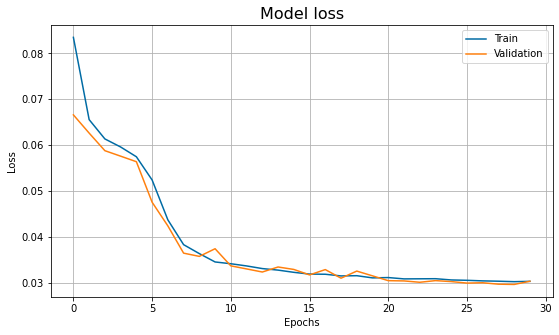

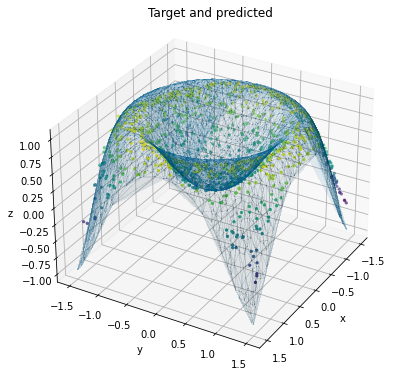

In [325]:
plt.figure(figsize=(9,5))
plt.plot(hist3D.history['loss'])
plt.plot(hist3D.history['val_loss'])
plt.title('Model loss', fontsize=16)
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

x_pred=np.random.uniform(-1.5, 1.5, int(1e3))
y_pred=np.random.uniform(-1.5, 1.5, int(1e3))
pred=np.stack([x_pred,y_pred],axis=1)
z_pred=mod3D.predict(pred)
plot3D((x_pred,y_pred,z_pred[:,0]),targ,'predicted')

### Comments on the results: very nice

Both the loss function and the predicted values obtained from the model look very promising. It seems that our choice of parameters was reasonable.